# import libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import pandas_datareader.data as web
import datetime
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
quandl.ApiConfig.api_key = 'JCTsqr8QXQyhimdy2JVd'

In [11]:
#One of my research questions was to see if there was a correlation between personal income and the uptake of EVS. I have chosen the Real Median Personal Income in the United States for this reason. 

In [5]:
# Importing the Federal Reserve Economic Data "Real Median Personal Income in the United States" variable.

data = quandl.get('FRED/RPI')
data.head(5)

QuandlError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

In [13]:
# Define the start and end dates # alternative retrieval method sourced from ChatGPT
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.now()

In [15]:
# Fetch the Median Personal Income data from FRED
data = web.DataReader('RPI', 'fred', start, end)

# Subsetting, wrangling and cleaning data

In [17]:
data.head()

,RPI
DATE,
2000-01-01,11441.669
2000-02-01,11488.814
2000-03-01,11520.777
2000-04-01,11582.719
2000-05-01,11624.340


In [19]:
data.shape

(301, 1)

In [21]:
data.columns

Index(['RPI'], dtype='object')

In [23]:
type(data)

pandas.core.frame.DataFrame

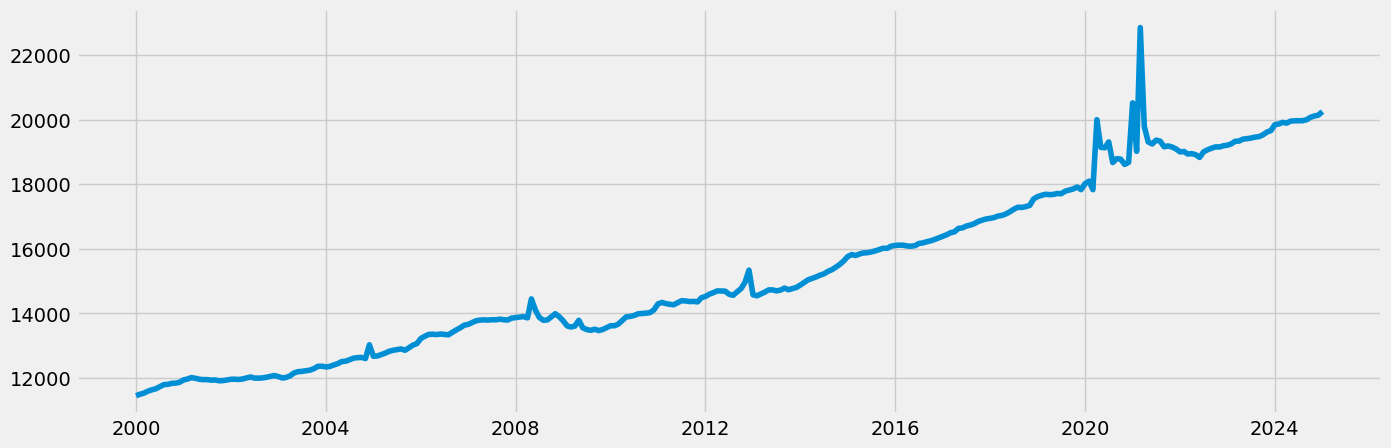

In [25]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [27]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [29]:
data_2.head()

,DATE,RPI
0,2000-01-01,11441.669
1,2000-02-01,11488.814
2,2000-03-01,11520.777
3,2000-04-01,11582.719
4,2000-05-01,11624.340


In [31]:
data_2.tail()

,DATE,RPI
296,2024-09-01,19993.464
297,2024-10-01,20067.376
298,2024-11-01,20111.246
299,2024-12-01,20136.069
300,2025-01-01,20248.025


In [33]:
data_sub = data_2.loc[(data_2['DATE'] >= '2000-01-01') & (data_2['DATE'] < '2025-01-01')]

In [35]:
data_sub.shape

(300, 2)

In [37]:
data_sub.head()

,DATE,RPI
0,2000-01-01,11441.669
1,2000-02-01,11488.814
2,2000-03-01,11520.777
3,2000-04-01,11582.719
4,2000-05-01,11624.340


In [39]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['DATE']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['DATE'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,RPI
datetime,
2000-01-01,11441.669
2000-02-01,11488.814
2000-03-01,11520.777
2000-04-01,11582.719
2000-05-01,11624.340


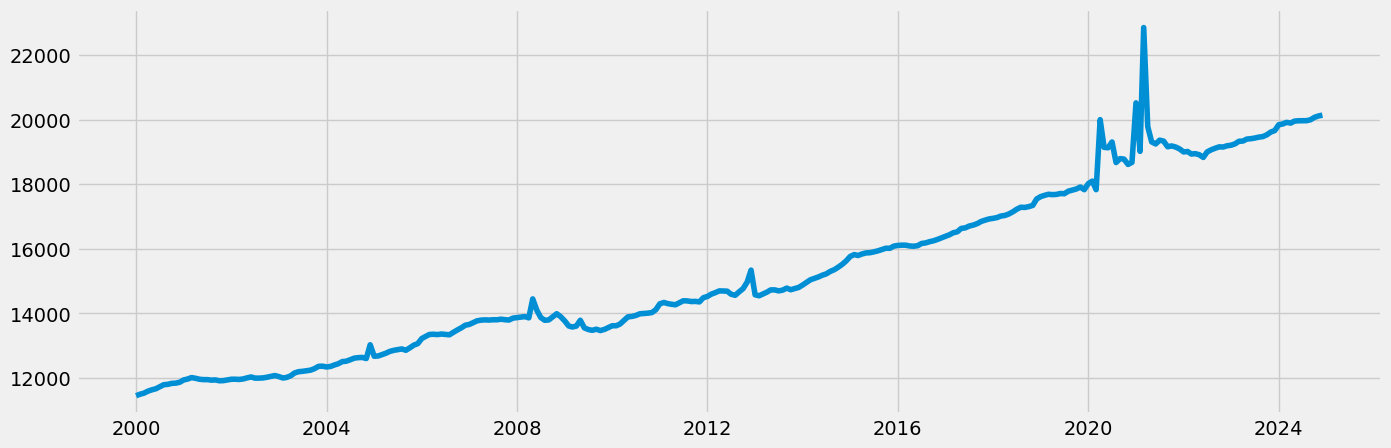

In [41]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [43]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

RPI    0
dtype: int64

In [45]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

# Time Series Analysis: Decomposition

In [47]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [49]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

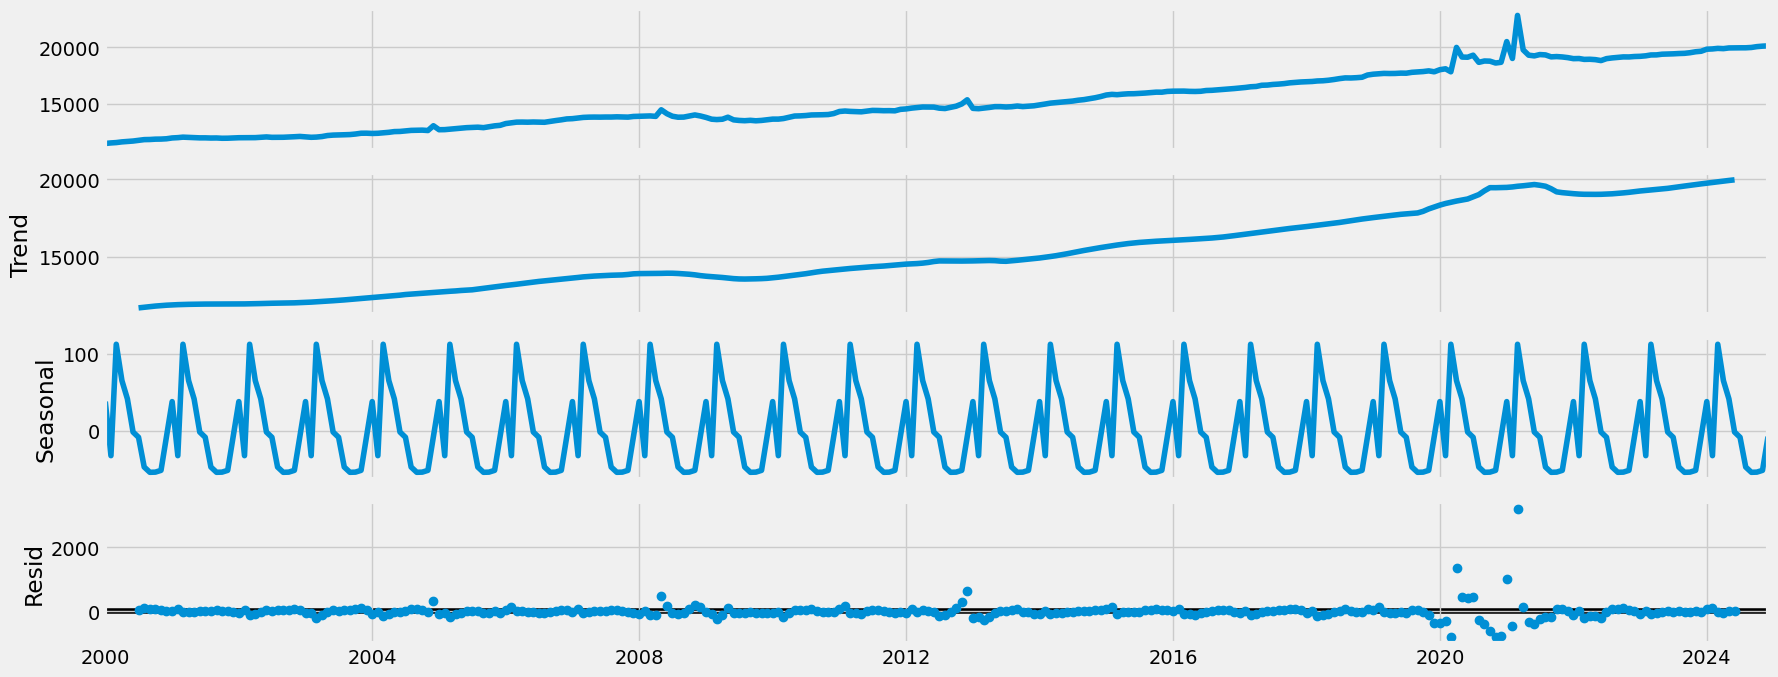

In [51]:
# Plot the separate components

decomposition.plot()
plt.show()

In [53]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['RPI']) 

Dickey-Fuller Stationarity test:
Test Statistic                   0.458796
p-value                          0.983565
Number of Lags Used             12.000000
Number of Observations Used    287.000000
Critical Value (1%)             -3.453342
Critical Value (5%)             -2.871664
Critical Value (10%)            -2.572164
dtype: float64


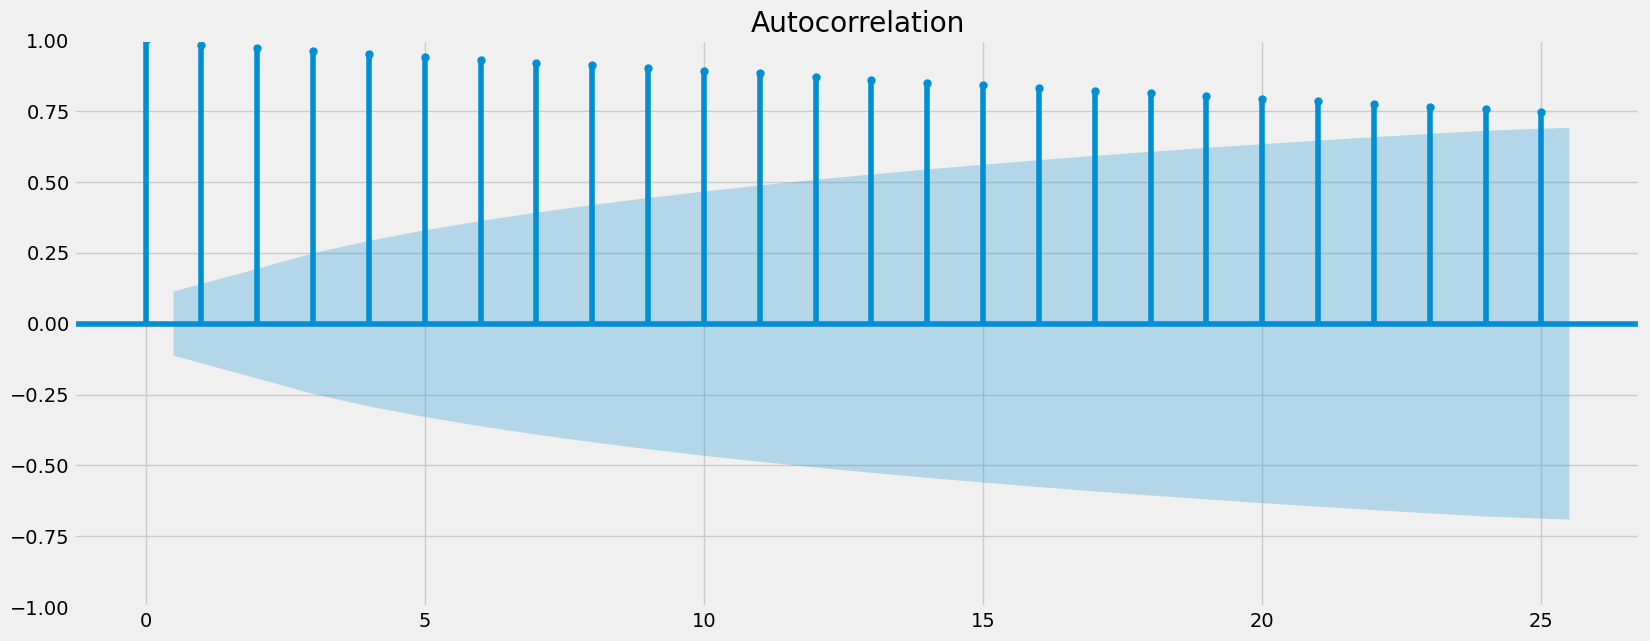

In [55]:
# p-value 0.98 null hyp cannot be rejected # critical value(s) lower than test statistic # not stationary
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Stationarising the data

In [57]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [59]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [61]:
data_diff.head()

,RPI
datetime,
2000-02-01,47.145
2000-03-01,31.963
2000-04-01,61.942
2000-05-01,41.621
2000-06-01,33.121


In [63]:
data_diff.columns

Index(['RPI'], dtype='object')

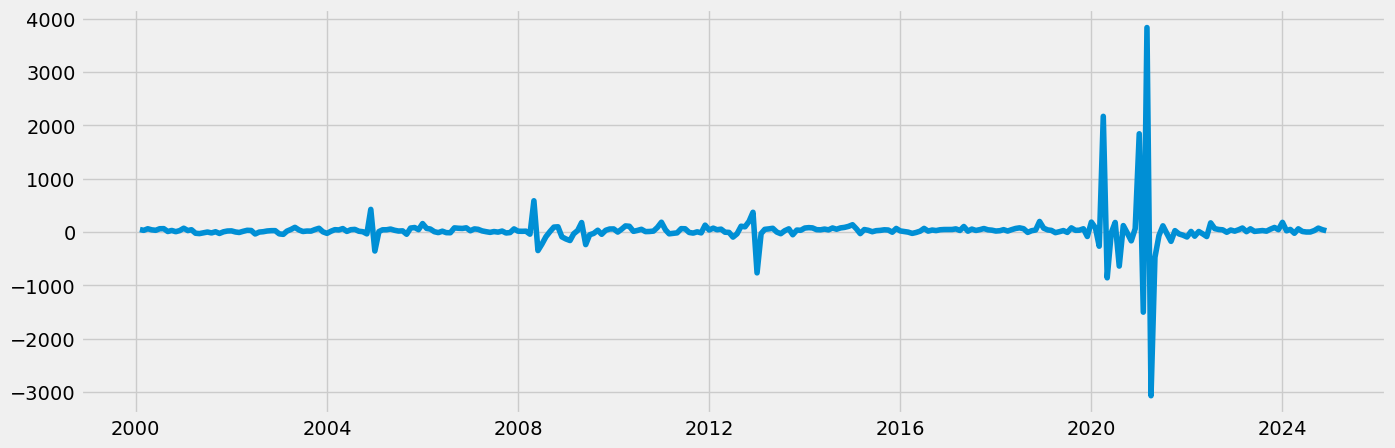

In [65]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [67]:
dickey_fuller(data_diff) #test stat lower than critical values, p-value lower than 0.05

Dickey-Fuller Stationarity test:
Test Statistic                  -4.419271
p-value                          0.000274
Number of Lags Used             11.000000
Number of Observations Used    287.000000
Critical Value (1%)             -3.453342
Critical Value (5%)             -2.871664
Critical Value (10%)            -2.572164
dtype: float64


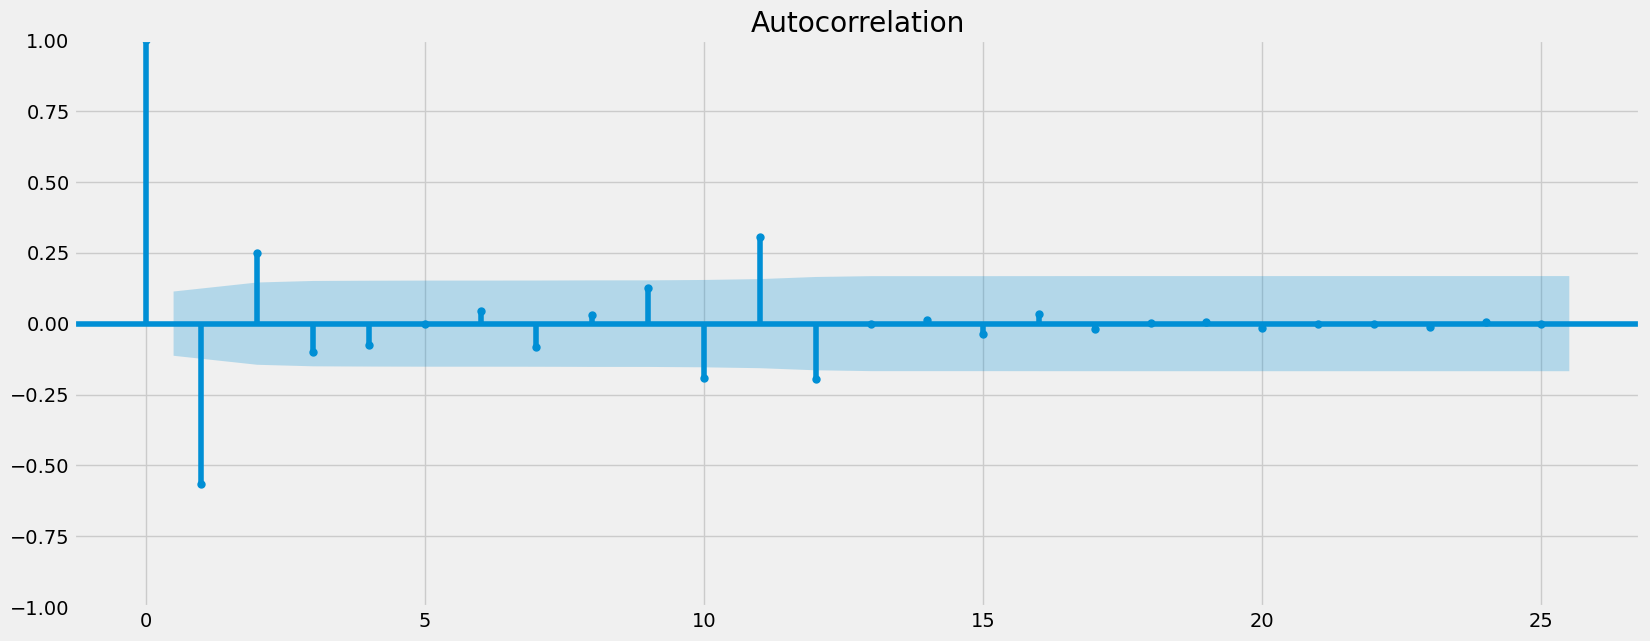

In [69]:
plot_acf(data_diff)
plt.show()

In [ ]:
# Test statistic smaller than critical value = can reject null hypothesis (and consider series stationary)
